# Pure Premium GLM

Now that I've done all the pre-modeling work, I'm ready to finally build a model!

I'll construct a basic pure premium Tweedie GLM based on the decisions I've made in the prior notebooks.

# Packages and Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils import *

# Import Data

In [2]:
df = pd.read_parquet("data/df_train_final.parquet") # final output from prior cat_features notebook

# Train GLM

In [3]:
y_col = "ClaimAmount_capped_1MIL"
exposure_col = "Exposure"

cat_cols = ["Area_bin1", "VehBrand_bin1", "VehGas", "Region_bin1",
            "VehPower_cap_flag", "VehAge_cap_flag", "DrivAge_cap_flag",
            "BonusMalus_cap_flag", "Density_cap_flag"]

rhs = " + ".join(
    [f"C({c})" for c in cat_cols] + [
        "VehPower_capped",
        "bs(VehAge_capped, df=3, degree=3, include_intercept=False)",
        "bs(DrivAge_capped, knots=(26, 29, 32), degree=3, include_intercept=False)",
        "bs(BonusMalus_capped, knots=(80,), degree=3, include_intercept=False)",
        "bs(Density_capped, knots=(57,), degree=3, include_intercept=False)",
    ]
)

formula = f"{y_col} ~ {rhs}"

glm = smf.glm(
    formula=formula,
    data=df,
    family=sm.families.Tweedie(var_power=1.94, link=sm.families.links.Log()),
    freq_weights=df[exposure_col],
).fit() 

In [4]:
print(glm.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     ClaimAmount_capped_1MIL   No. Observations:               536891
Model:                                 GLM   Df Residuals:                286816.10
Model Family:                      Tweedie   Df Model:                           43
Link Function:                         Log   Scale:                          492.75
Method:                               IRLS   Log-Likelihood:            -1.9076e+05
Date:                     Mon, 15 Dec 2025   Deviance:                   1.2454e+07
Time:                             11:09:27   Pearson chi2:                 1.41e+08
No. Iterations:                        100   Pseudo R-squ. (CS):          0.0006412
Covariance Type:                 nonrobust                                         
                                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------

Great! Now I have a first-draft GLM. Most of the p-values aren't significant, but that's a poor way to approach this problem. The signal of the splines and the categorical variables are spread across multiple coefficients. I can't remove just C(Area_bin1)[T.E]- I need to know to remove Area in whole. In a later step, I'll use regularization methods and other controls (elastic net, bootstrapped confidence intervals) to figure out a variable selection or dampening process.

# Diagnostics

 decile  exposure  actual_pp    pred_pp  actual_lift  pred_lift
      1  28685.72  49.817035  30.435406     0.318180   0.322828
      2  28685.66  85.579868  42.888678     0.546596   0.454920
      3  28686.27  78.909166  51.079678     0.503991   0.541801
      4  28686.15 100.190324  58.596460     0.639913   0.621532
      5  28685.73  99.772993  66.149079     0.637247   0.701642
      6  28686.16  98.086636  74.496939     0.626477   0.790188
      7  28686.13 148.760023  85.005768     0.950126   0.901655
      8  28686.20 158.145436 101.374006     1.010071   1.075273
      9  28685.14 220.541527 136.343109     1.408593   1.446189
     10  28686.94 525.872626 296.399594     3.358734   3.143906


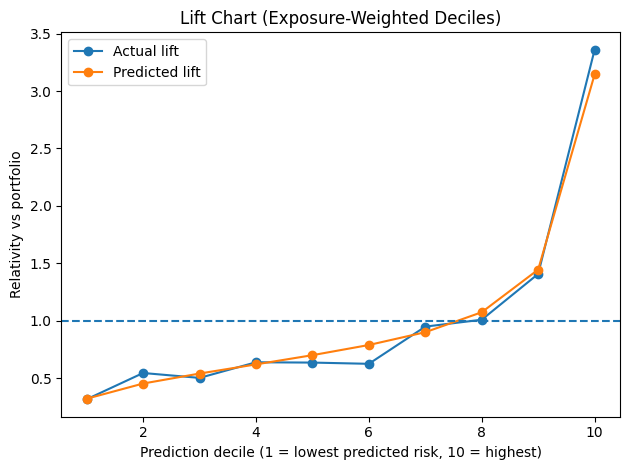

In [5]:
pred_pp = glm.predict(df)  # since y is pure premium in your setup

g, port_act, port_pred = lift_table_by_decile(
    df, y_pp_col="pure_premium_capped_1MIL", pred_pp=pred_pp, exposure_col="Exposure"
)

print(g[["decile","exposure","actual_pp","pred_pp","actual_lift","pred_lift"]].to_string(index=False))
plot_lift(g)

Awesome! But a little expected. 

So this is a good lift chart generally. I see that the predictions properly fit to the actuals for each decile of predictions. I note a slight underprediction on Decile 10, I also see that Deciles 2, 5 and 6 are not quite segmented well- there's slight reversals. But overall this is a good lift chart.

Here's the problem: this is on the *training* dataset. The model saw this data and fit to it using the features I fed it. It is of course going to fit well to the actuals- that is what fitting a model is meant to do. I wonder how well this fits on the held out data? I'll find out later, but this model *could* be slightly overfit to the training dataset. This is something to explore next.

# Conclusions

I have a decent GLM model now. What are my next steps? I need to produce some additional models. I'm worried about overfitting with this GLM. Nonetheless, this gives me a good initial set of an "indicated" pricing scheme.

Next, I'll fit an elastic net. That will do some regularization on these coefficients and give me some measure of an "out of sample optimized" model fit. I will take this as a second set of "indications."

After that, I'll try to do a Bootstrapped GLM. I want to put some sort of reasonable range around the GLM coefficients that reflect sampling variance. 

I'll put all of those model results together along with some simple univariate data to make a factor selection exhibit. I'll use that to make a final selection of factors for every variable and come up with a final model using those selections.

I'll then have GLM, Elastic Net, Boostrapped GLMs and Final Selected models out of this phase of the process.

This is not a typical approach most data scientists take when faced with this problem. Most data scientists would *never* make space for manual, human-guided factor selections. I prefer this option when working with US insurance data. I'll discuss this later in the procedure, once I have some concrete examples to look at. Since this is so controversial and atypical, I also plan to take a more "data science"-centric approach and fit a model based on "machine learning" style approaches, without considering inference or interpretability as a goal. I'm curious to see how these different techniques stack up to each other.

